# Primena **DBSCAN** algoritma na podatke o geografskoj lokaciji aerodroma

## Vršimo neophodne *import* - e

In [1]:
import pandas as pd # Pandas biblioteka za DataFrame strukturu
import numpy as np  # Numpy biblioteka
from matplotlib import pyplot as plt # Biblioteka za vizuelizaciju
from mpl_toolkits.basemap import Basemap # Biblioteka za vizuelizaciju mape
from copy import deepcopy
import math

from sklearn.preprocessing import MinMaxScaler # Skaliranje vrednosti atributa na isti interval, (0,1)
from sklearn.metrics import silhouette_score # Senka koeficijent, mera kvaliteta klasterovanja
from sklearn.cluster import DBSCAN # DBSCAN algoritam za klasterovanje

## Učitavanje podataka i upoznavanje sa njima

In [2]:
# Napomena: Ovo su podaci već delom preprocesirani u IBM-SPSS modeleru
df = pd.read_csv("../Data/airports_PreprocessedData.csv")
whole_set = len(df)
df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source,Altitude_CATEGORY,Coord_X,Coord_Y,Coord_X_Nearest_End
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16158.656679,-675.910224,3840.837979
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16202.779039,-578.707337,3796.715620
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16036.849596,-647.581008,3962.645063
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16306.913146,-730.158416,3692.581512
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16361.818285,-1049.523652,3637.676374


## Vizuelizacija - pre primene algoritma

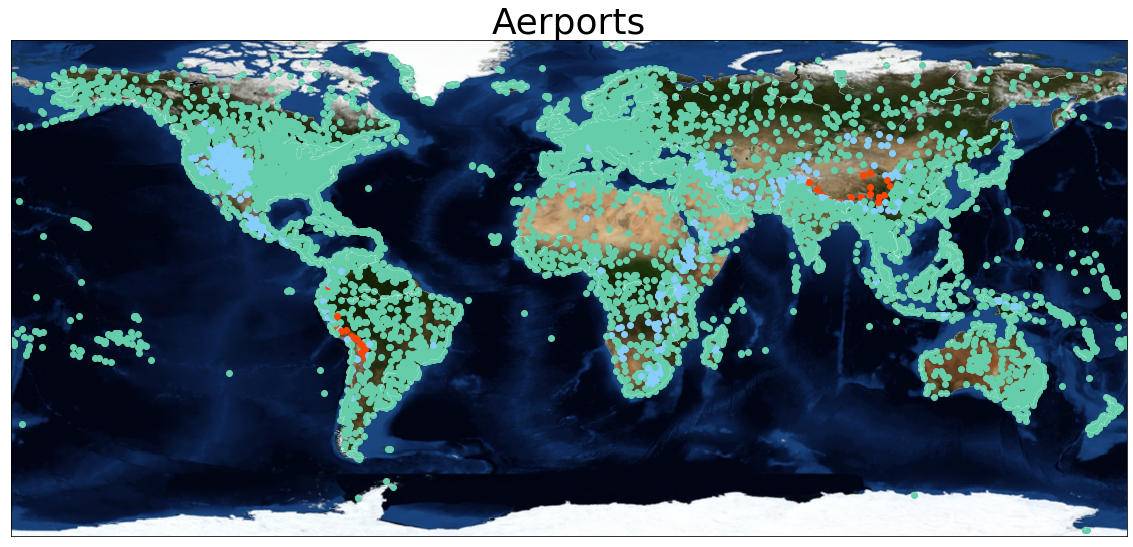

In [3]:
plt.rcParams["font.size"] = 30

fig = plt.gcf()
fig.set_size_inches(20, 20) # Veličina mape

# Biramo cilindričnu projekciju
m = Basemap(projection='cyl',    
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(list(df['Longitude']),list(df['Latitude']))  # transform coordinates

colors = ['mediumaquamarine','lightskyblue','orangered'] # Aerodrome bojimo na mapi u zavisnosti od visinske kategorije
category_altitude = list(df['Altitude_CATEGORY'])

plt.title("Aerports")
for i in range(0,len(x)):
    plt.scatter(x[i],y[i], color = colors[category_altitude[i] - 1])

plt.savefig("../Visualisations/Data_on_map_with_high_categories.png")
plt.show()

## Preprocesiranje podataka
### Izdvajanje karakteristika po kojima vrsimo klasterovanje
#### (za početak ćemo vršiti klasterovanje samo po atributima 
####  *Longitude* i *Latitude*  (trenutno ćemo da zanemarimo nadmorsku visinu)

In [4]:
features = df.columns[6:8]
df[features].head()

,Latitude,Longitude
0,-6.081690,145.391998
1,-5.207080,145.789001
2,-5.826790,144.296005
3,-6.569803,146.725977
4,-9.443380,147.220001


## Preprocesiranje podataka
### Skaliranje raspona vrednosti svih atributa po kojima
### vršimo skaliranje na interval $(0,1)$

In [5]:
scaler = MinMaxScaler()
scaler.fit(df[features]) # Za svaki atribut nalazi najveću i najmanju vrednost, na osnovu njih će skalirati
x = pd.DataFrame(scaler.transform(df[features])) # Skaliranje vrednosti
x.columns = features
x.head()

,Latitude,Longitude
0,0.486433,0.903957
1,0.491502,0.905060
2,0.487910,0.900911
3,0.483603,0.907664
4,0.466947,0.909037


## Primena algoritma **DBSCAN** za različite vrednosti parametara i upoređivanje rezultata

  Dobijena vizuelizacija nam može pomoći pri proceni za odabir parametara, $\varepsilon$ i minimalnog broja suseda. Više puta ćemo pokušavati sa različitim kombinacijama. 

In [6]:
# Funkcija za opisivanje klastera
def describe_clusters(df, features ,n): # n - broj klastera
    if 'labels' not in df.columns:
        print("Ne postoji kolona sa klasterima ili se drugacije naziva")
        return
    print(" ~ Opis dobijenih klastera: ~\n\n\n")
    
    noise_cluster =  df.loc[ df['labels'] == -1]
    noise_num_of_members = len(noise_cluster)
    if noise_num_of_members != 0:
        print("********** Klaster suma (eng. Noise) : **********\n\n\n")
        print("Udeo: {} % ".format( int((noise_num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(noise_cluster.describe()[features])
        print("\n\n\n\n\n")
        
    for i in range(0,n):
        this_cluster = df.loc[ df['labels'] == i]
        num_of_members = len(this_cluster)
        if num_of_members == 0: # Ako se dogodi da imamo prazan klaster
            continue              # Nema potrebe ispisivati informacije o njemu
        print("********** Klaster {} : **********\n\n\n".format(i))
        print("Udeo: {} % ".format( int((num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(this_cluster.describe()[features])
        print("\n\n\n\n\n")

In [7]:
colors = ['red','deepskyblue','gold','lightgreen','palevioletred','purple','orangered',
          'blueviolet','darkblue','cadetblue','indigo','tomato','mediumaquamarine',
          'olive','c','maroon','darkseagreen','cornflowerblue','orchid','lightcoral',
          'lavender','slateblue','yellowgreen','forestgreen','antiquewhite', 'sienna',
          'darkcyan','deeppink','thistle','plum','powderblue','sandybrown','m',
          'chartreuse','lemonchiffon','mistyrose','darkmagenta','brown','peru',
          'chocolate','royalblue']

# Prvo ćemo napisati funkciju za treniranje modela, ispis rezultata i prikaz
# df - originalni DataFrame koji obrađujemo
# x - DataFrame sa skaliranim vrednostima i izdvojenim karakteristikama
# eps i min_samples parametri za DBSCAN
def model_DBSCAN(df,x,eps,min_samples):
    est = DBSCAN(eps = eps,min_samples = min_samples) # Pravimo instancu modela
    est.fit(x) # Treniramo model
    
    df['labels'] = est.labels_ # Dodeljujemo dobijene klastere
    
    senka_koeficijent = silhouette_score(x, est.labels_)
    # Ispisujemo kvalitet klasterovanja
    print("** Dobijeni senka koeficijent je {} ".format(senka_koeficijent))
    if senka_koeficijent <= 0.0:
        print("-- Los kvalitet klasterovanja (POOR)")
    
    elif senka_koeficijent <= 0.5:
        print("-- Nije dobar kvalitet klasterovanja (FAIR)")
    
    elif senka_koeficijent < 0.7:
        print("-- Dobar kvalitet klasterovanja (GOOD)")
        
    else:
        print("-- Najbolji kvalitet klasterovanja, klasteri su gusti i dobro grupisani (GOOD)")
    
    num_of_clusters = max(df['labels']) + 1
    describe_clusters(df=df,n=num_of_clusters, features = features)
    
    # Iscrtavamo klastere na mapi
    
    figure = plt.figure(figsize= (20,9.5))
    for i in range(-1,num_of_clusters):
        
        if i == -1: # Da li trenutno crtamo šum
            label = "noise"
            color = "lightgray"
        else:
            label = "cluster %d"%i
            color = colors[i]
        
        # Elementi koji pripadaju klasteru koji trenutno crtamo
        current_cluster = df[df['labels'] == i]
        plt.scatter(current_cluster['Longitude'], current_cluster['Latitude'], 
                   color = color, label = label)
    plt.legend()
    plt.show()
    

** Dobijeni senka koeficijent je 0.3035633226464082 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 7 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  536.000000  536.000000
mean    18.773204   32.891100
std     44.097796  123.558714
min    -90.000000 -179.876999
25%    -17.353275  -68.663302
50%     19.501750   73.240501
75%     62.095846  163.658993
max     82.517799  179.951004






********** Klaster 0 : **********



Udeo: 46 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3539.000000  3539.000000
mean     30.961763    58.658619
std      25.324514    53.093508
min     -42.836102   -27.090799
25%      21.261401    10.018134
50%      37.445663    41.019402
75%      49.567084   111.195390
max      77.896944   174.365005






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2889.000000 

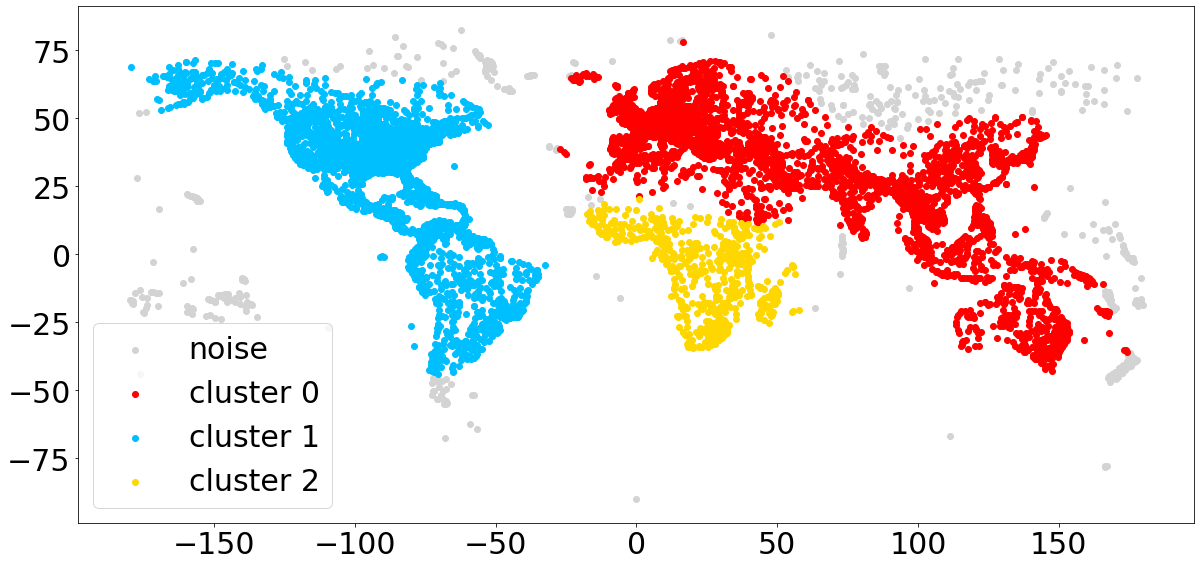

In [8]:
# Prva procena: eps = 0.05 , minimalan broj suseda = 100

model_DBSCAN(df = df,x = x,eps = 0.05, min_samples= 100)

### Analiza dosadašnjih rezultata i procene za dalje pokušaje

  Na ovoj slici vidimo i problem sa našim podacima. U Evropi, Severnoj Americi, po obodima Južne Amerike i Afrike je prilično velika gustina aerodroma. Za razliku od tih delova sveta, u većem delu Azije nema toliko gustih delova koji bi obuhvatili ostale aerodrome u svoj klaster.
  
  **Novi pokušaj:** Ostavićemo trenutno isto $\varepsilon$, a pokušaćemo sa manjim brojem
  minimalnog broja suseda.

** Dobijeni senka koeficijent je 0.2490375213709907 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 11 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  890.000000  890.000000
mean    14.451247   32.535653
std     37.146088  102.675310
min    -90.000000 -179.876999
25%    -16.506575  -55.535186
50%     11.809185   43.223650
75%     48.696825  105.105702
max     82.517799  179.951004






********** Klaster 0 : **********



Udeo: 44 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3383.000000  3383.000000
mean     31.074291    57.840172
std      25.760997    53.792200
min     -42.836102   -27.090799
25%      20.878200     9.505329
50%      38.139702    36.583000
75%      50.025582   113.064027
max      77.896944   174.365005






********** Klaster 1 : **********



Udeo: 35 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2692.000000

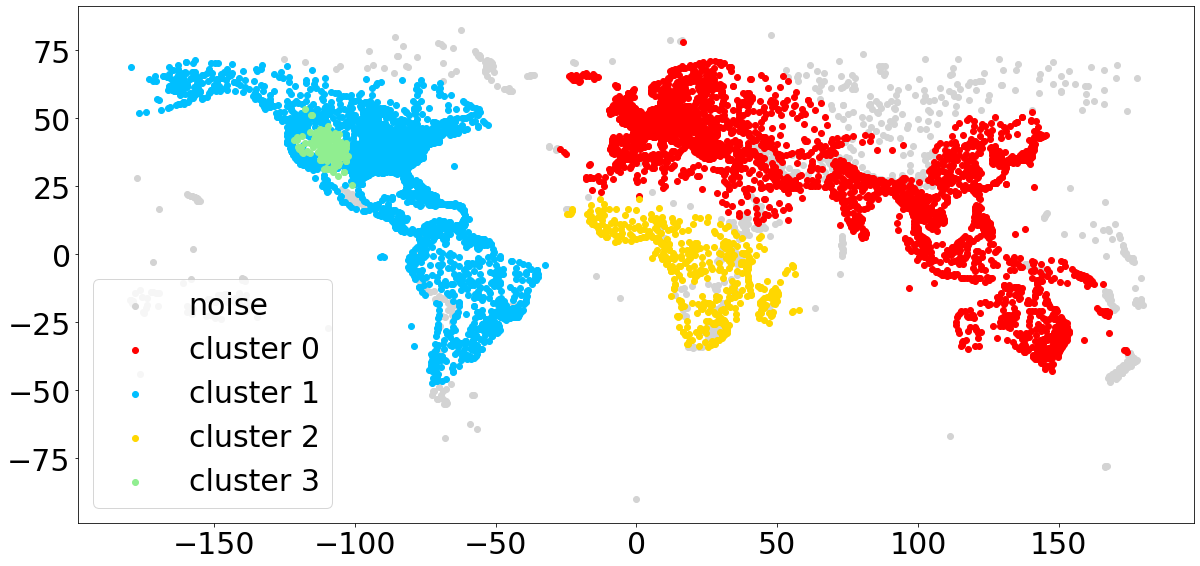

In [34]:
# Nova procena: eps = 0.05, minimalan broj suseda = 88

model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 88)

** Dobijeni senka koeficijent je 0.3939959125988138 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  436.000000  436.000000
mean    21.499054   24.730754
std     44.993897  126.087764
min    -90.000000 -179.876999
25%    -16.814400  -81.385900
50%     21.531500   73.077600
75%     63.335763  150.762226
max     82.517799  179.195999






********** Klaster 0 : **********



Udeo: 55 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4199.000000  4199.000000
mean     25.258304    54.778976
std      27.722398    52.193421
min     -42.836102   -28.715900
25%       5.414815    10.671760
50%      33.115002    34.778099
75%      48.027089   103.895001
max      78.246101   179.951004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2908.000000 

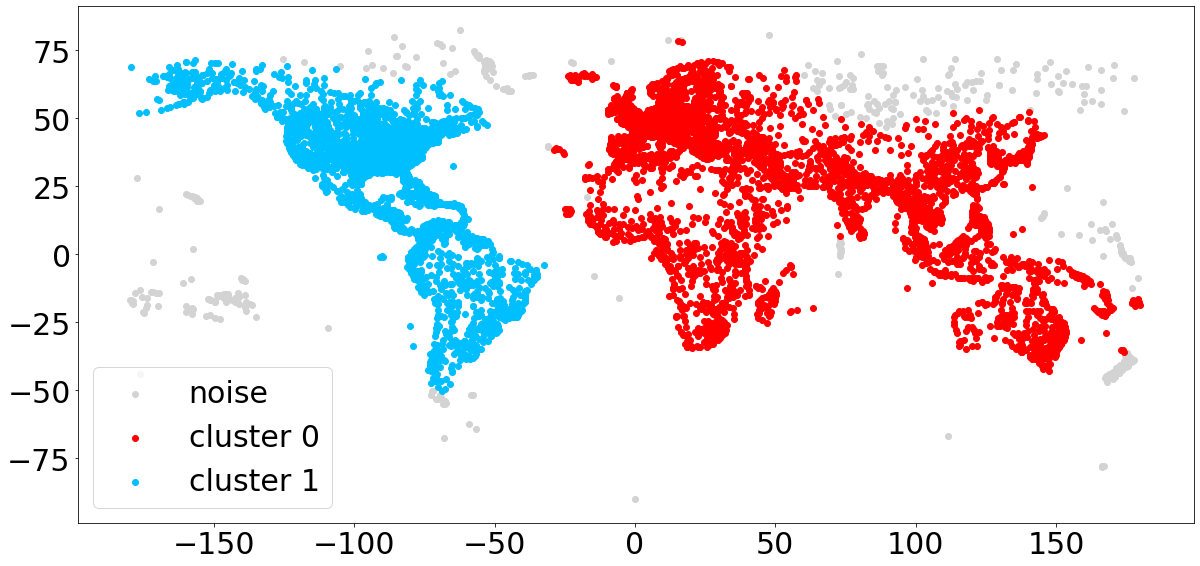

In [10]:
# Skoro sve tačke su ostale šum.
# Smanjujemo dalje minimalan_broj_suseda za isto epsilon
# Nova procena: eps = 0.1, minimalan_broj_suseda = 100

model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 80)

** Dobijeni senka koeficijent je 0.4001527691078875 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  404.000000  404.000000
mean    19.927586   21.427258
std     45.826660  128.373525
min    -90.000000 -179.876999
25%    -17.826174  -84.718339
50%     21.057901   72.929946
75%     63.704343  153.797051
max     82.517799  177.977997






********** Klaster 0 : **********



Udeo: 56 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4226.000000  4226.000000
mean     25.328260    55.048182
std      27.716465    52.254302
min     -42.836102   -28.715900
25%       5.526384    10.777985
50%      33.170250    34.990851
75%      48.072851   103.981575
max      78.246101   179.951004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2913.000000 

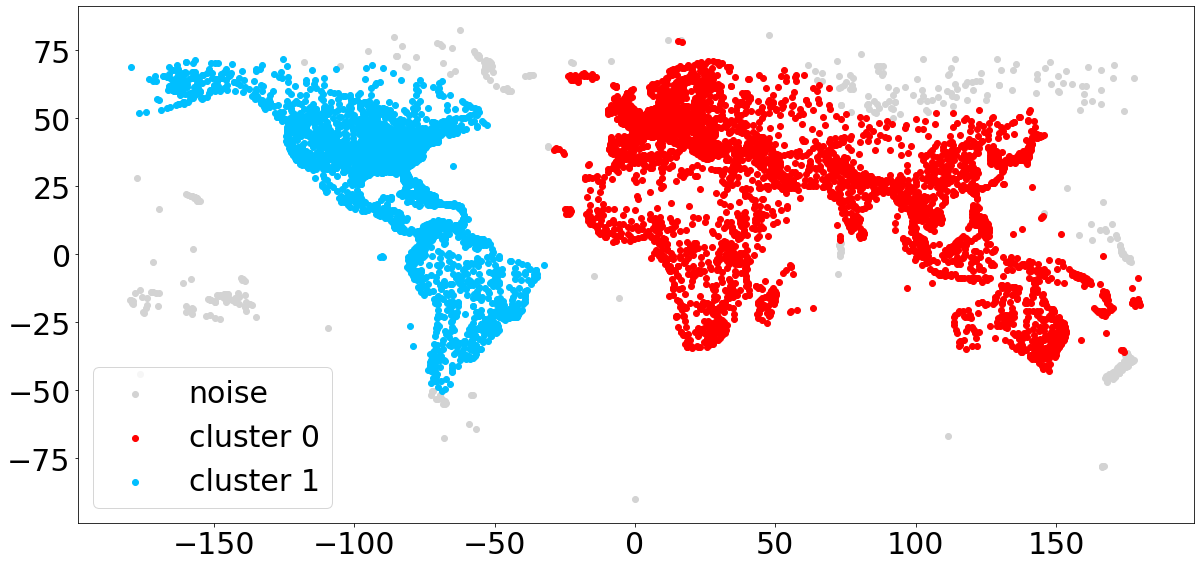

In [11]:
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 68)

** Dobijeni senka koeficijent je 0.40761719973062494 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 4 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  361.000000  361.000000
mean    17.458524   19.532449
std     46.568330  133.715911
min    -90.000000 -179.876999
25%    -19.079031 -138.570007
50%     16.728600   72.052222
75%     65.412498  162.688004
max     82.517799  177.977997






********** Klaster 0 : **********



Udeo: 56 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4255.000000  4255.000000
mean     25.443121    55.236407
std      27.719969    52.134087
min     -42.836102   -28.715900
25%       5.529896    10.929783
50%      33.411499    35.250000
75%      48.227750   103.839837
max      78.246101   179.951004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2927.000000

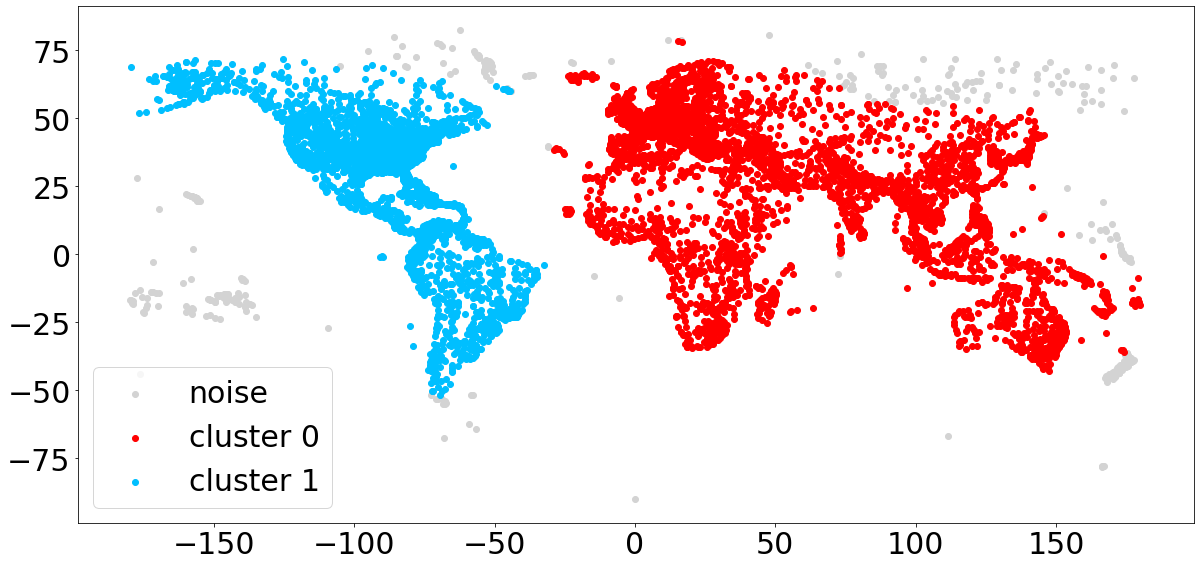

In [12]:
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 59)

** Dobijeni senka koeficijent je 0.33798230395549983 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 4 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  302.000000  302.000000
mean    27.798536   -8.827824
std     42.745916  127.448208
min    -90.000000 -179.876999
25%    -14.434625 -145.099243
50%     54.173116  -51.755181
75%     66.438244  116.932750
max     82.517799  177.740997






********** Klaster 0 : **********



Udeo: 56 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4259.000000  4259.000000
mean     25.461363    55.231104
std      27.734321    52.119153
min     -42.836102   -28.715900
25%       5.529896    10.929783
50%      33.425833    35.266300
75%      48.249373   103.813004
max      78.246101   179.951004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2927.000000

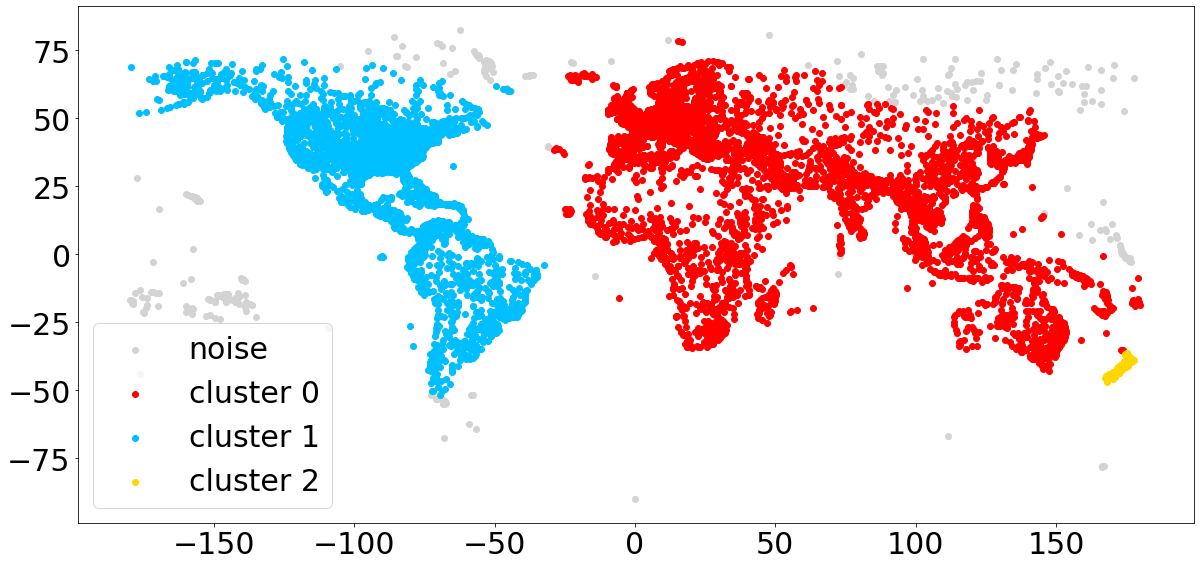

In [13]:
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 58)

** Dobijeni senka koeficijent je 0.30218347910531335 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 7 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  565.000000  565.000000
mean    20.352246   36.013888
std     43.516609  121.249969
min    -90.000000 -179.876999
25%    -17.013300  -67.198997
50%     21.152901   73.310501
75%     62.158600  162.688004
max     82.517799  179.951004






********** Klaster 0 : **********



Udeo: 46 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3499.000000  3499.000000
mean     31.043204    58.583504
std      25.179490    52.976611
min     -42.836102   -21.940599
25%      21.429450    10.001199
50%      37.466801    40.201000
75%      49.529050   111.087084
max      71.029701   173.285004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2892.000000

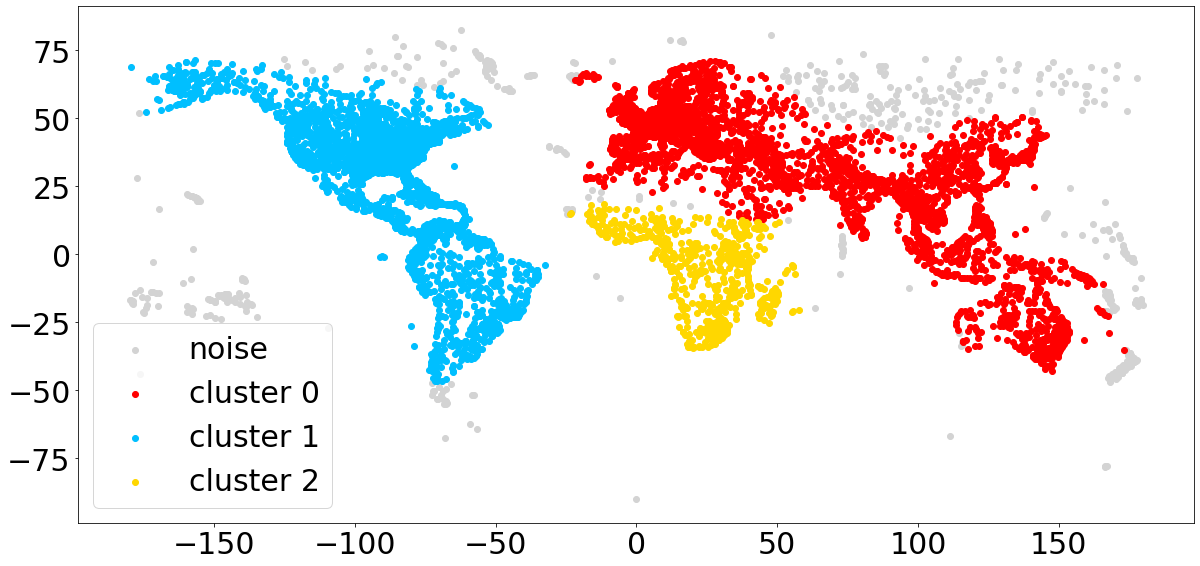

In [14]:
model_DBSCAN(df = df, x = x, eps = 0.045,min_samples = 80)

** Dobijeni senka koeficijent je 0.3942102659361043 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 5 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  452.000000  452.000000
mean    22.597887   21.964774
std     45.214819  124.681271
min    -90.000000 -179.876999
25%    -16.814400  -78.785648
50%     39.273750   71.759563
75%     64.387634  145.646503
max     82.517799  177.977997






********** Klaster 0 : **********



Udeo: 55 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4190.000000  4190.000000
mean     25.167763    54.950879
std      27.671919    52.160599
min     -42.836102   -27.090799
25%       5.298025    10.759900
50%      32.951650    34.840250
75%      47.986825   103.993777
max      71.029701   179.951004






********** Klaster 1 : **********



Udeo: 38 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2901.000000 

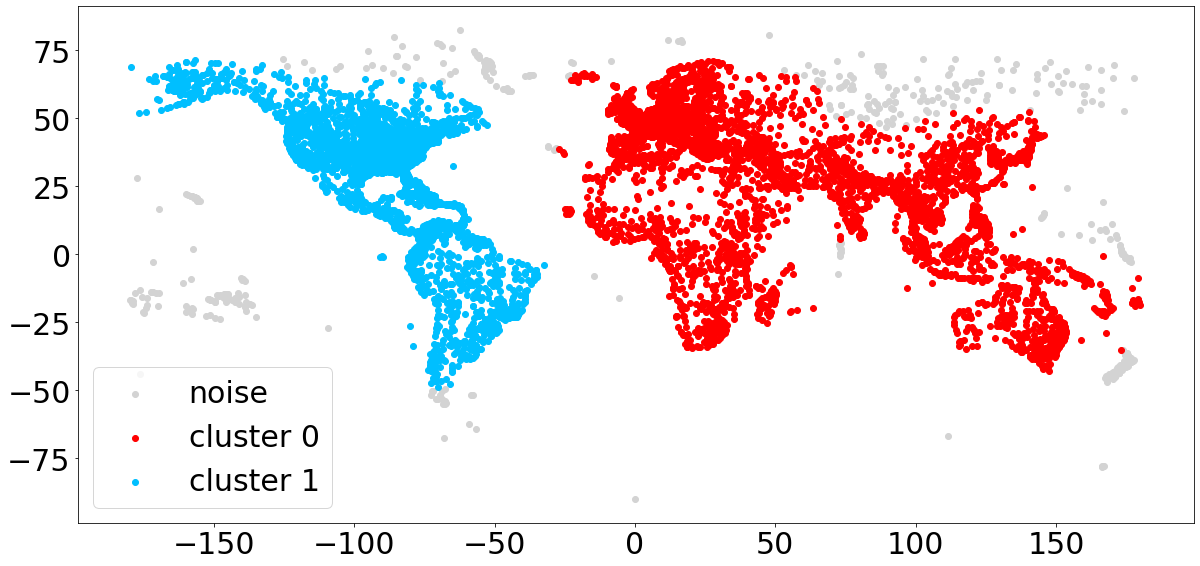

In [15]:
model_DBSCAN(df = df, x = x, eps = 0.045,min_samples = 60)

** Dobijeni senka koeficijent je 0.09503547327375003 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 13 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  1003.000000  1003.000000
mean     21.059799    25.712132
std      35.927082    97.651232
min     -90.000000  -179.876999
25%      -8.641335   -57.751199
50%      19.920500    41.634300
75%      56.375450   113.724370
max      82.517799   179.951004






********** Klaster 0 : **********



Udeo: 29 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2243.000000  2243.000000
mean     32.977804   -89.616204
std      15.122971    17.812660
min     -13.744900  -136.347000
25%      25.827499  -100.857502
50%      36.175301   -85.736000
75%      43.303850   -77.117654
max      60.172798   -50.516701






********** Klaster 1 : **********



Udeo: 37 % 
 - Deskriptivne statistike: 
          Latitude    Longitude

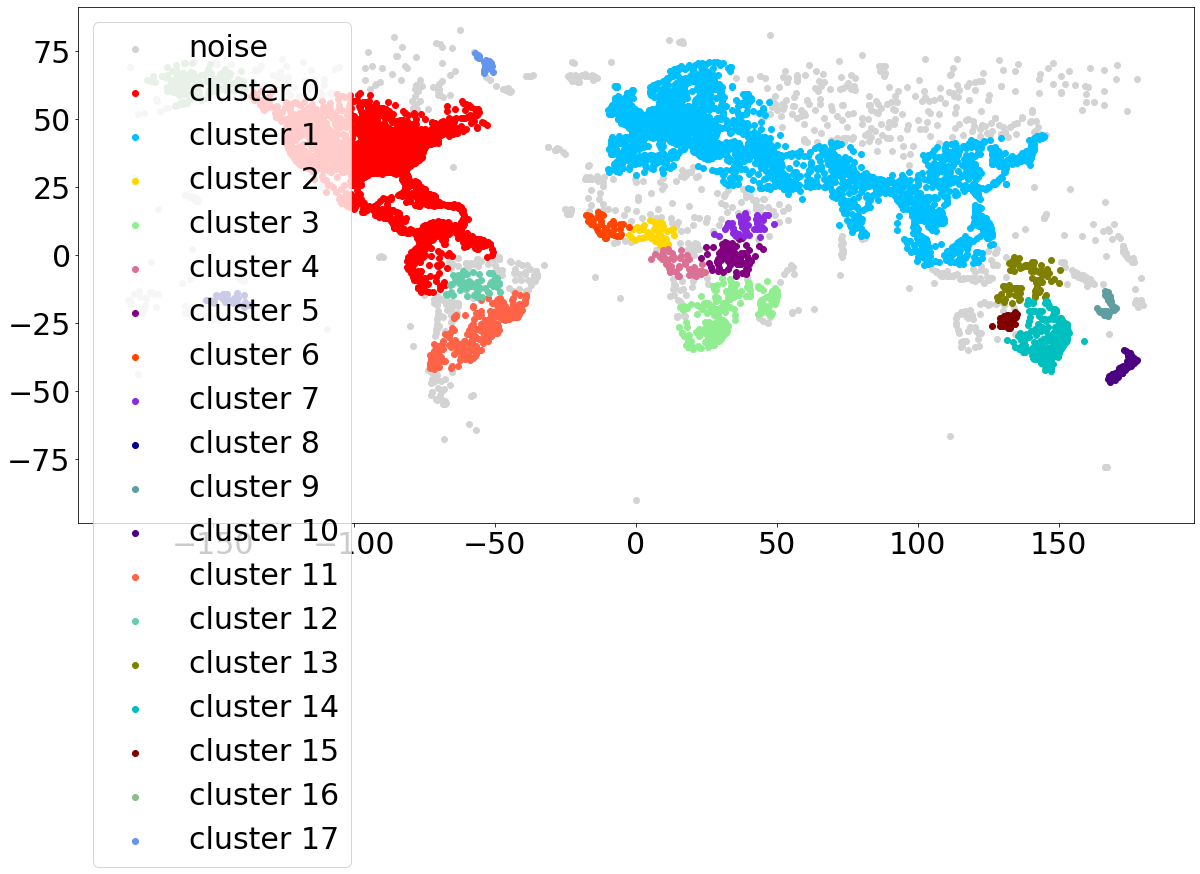

In [16]:
model_DBSCAN(df = df,x = x,eps = 0.02, min_samples = 25)

** Dobijeni senka koeficijent je 0.43503575688810986 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 2 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  164.000000  164.000000
mean    13.692436  -47.907140
std     42.135062  138.914542
min    -90.000000 -179.876999
25%    -16.814400 -156.956753
50%     -0.390980 -140.916496
75%     62.805195  115.983336
max     82.517799  177.740997






********** Klaster 0 : **********



Udeo: 58 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4398.000000  4398.000000
mean     24.962960    57.573752
std      28.657993    53.980234
min     -46.899700   -38.976552
25%       4.131045    11.280370
50%      33.120376    36.989243
75%      48.508412   106.873674
max      78.927498   179.951004






********** Klaster 1 : **********



Udeo: 39 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2981.000000

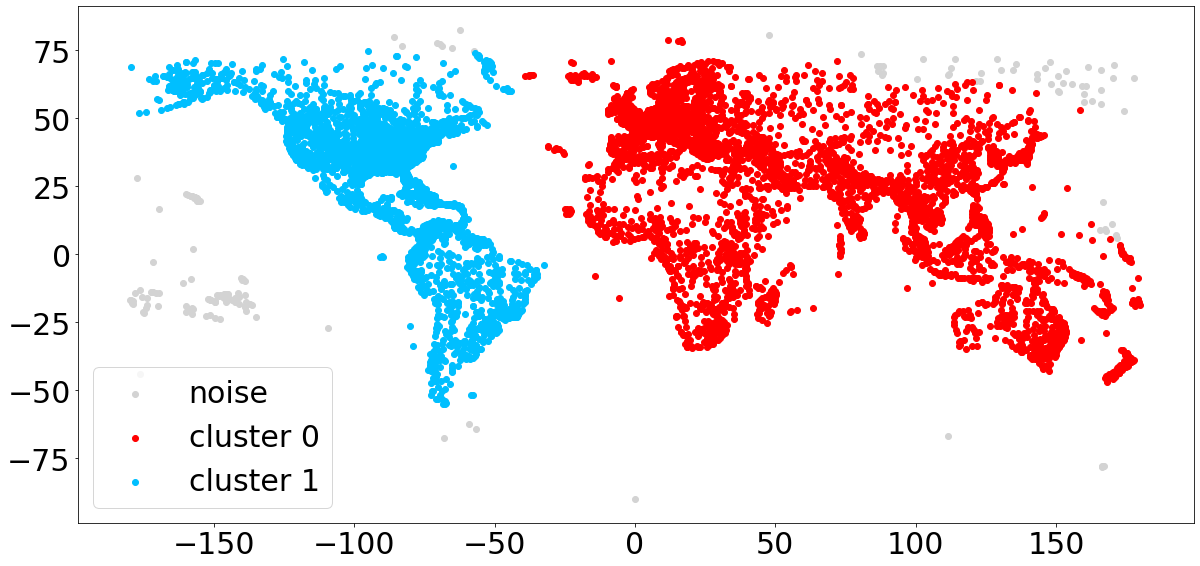

In [17]:
model_DBSCAN(df = df,x = x,eps = 0.07, min_samples = 90)

## Zaključak: 
Jasno je da zbog različite gustine podataka ne možemo dobiti bolje klasterovanje primenom ovog algoritma. Iako smo samo probali sa samo izdvojenim atributima 'Latitude' i 'Longitude', jasno je da zbog istog problema ne bi bio bolji rezultat ni sa izdvojenim atributima 'Latitude', 'Longitude' i 'Altitude', ni sa pristupom 'Longitude', 'Latitude' i 'Altitude_CATEGORY'. Ostavićemo primere i sa druga dva pristupa.

Pre nego što pokusamo sa izvršavanjem algoritma, moramo da preprocesiramo kategorički atribut 'Altitude_CATEGORY'. Imamo 3 kategorije i za svaku od njih pravimo jedan binarni atribut. Instanca neće imati 0 za tacno jedan atribut, koji odgovara vrednosti  atributa 'Altitude_CATEGORY'. Zbog računanja Euklidskog rastojanja i jednakog uticaja, umesto jedinice koristimo vrednost $\sqrt{\frac{1}{2}}$ .

In [18]:
features = ['Longitude','Latitude'] # Izdvajamo i skaliramo vrednosti atributa Longitude i Latitude
x = df[features]
scaler = MinMaxScaler().fit(x)
x = pd.DataFrame(scaler.transform(x))
x.columns = features

x['Altitude_CATEGORY'] = df['Altitude_CATEGORY']
#x = deepcopy( df[features] )

x['CAT_1'] = 0.0   # Nova binarna 3 atributa koji će odgovarati svakoj od mogućih kategorija
x['CAT_2'] = 0.0
x['CAT_3'] = 0.0
fixed_value = math.sqrt(0.5) # Ne-nula vrednost za atribute

for i in range(1,4):  # Zamenjujemo nule na odgovarajućim vrednostima
    x.loc[x['Altitude_CATEGORY'] == i, 'CAT_%d'%i] = fixed_value

x.head()

,Longitude,Latitude,Altitude_CATEGORY,CAT_1,CAT_2,CAT_3
0,0.903957,0.486433,2,0.000000,0.707107,0.0
1,0.905060,0.491502,1,0.707107,0.000000,0.0
2,0.900911,0.487910,2,0.000000,0.707107,0.0
3,0.907664,0.483603,1,0.707107,0.000000,0.0
4,0.909037,0.466947,1,0.707107,0.000000,0.0


In [25]:
# Sada još da uklonimo atribut Altitude_CATEGORY
features = ['Latitude','Longitude','CAT_1','CAT_2','CAT_3']
x = x[features]
x.head()
features = ['Latitude','Longitude']

** Dobijeni senka koeficijent je 0.2615997908493082 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 9 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  739.000000  739.000000
mean    14.083527   24.693491
std     37.200072  103.937053
min    -90.000000 -179.876999
25%    -16.478851  -66.512749
50%     11.975000   36.978485
75%     45.613902  102.253997
max     82.517799  177.977997






********** Klaster 0 : **********



Udeo: 46 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3500.000000  3500.000000
mean     30.577183    59.435599
std      26.097099    54.718048
min     -42.836102   -28.715900
25%      19.074349     9.791660
50%      37.953498    39.330749
75%      49.992101   114.220792
max      78.246101   179.951004






********** Klaster 1 : **********



Udeo: 36 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2717.000000 

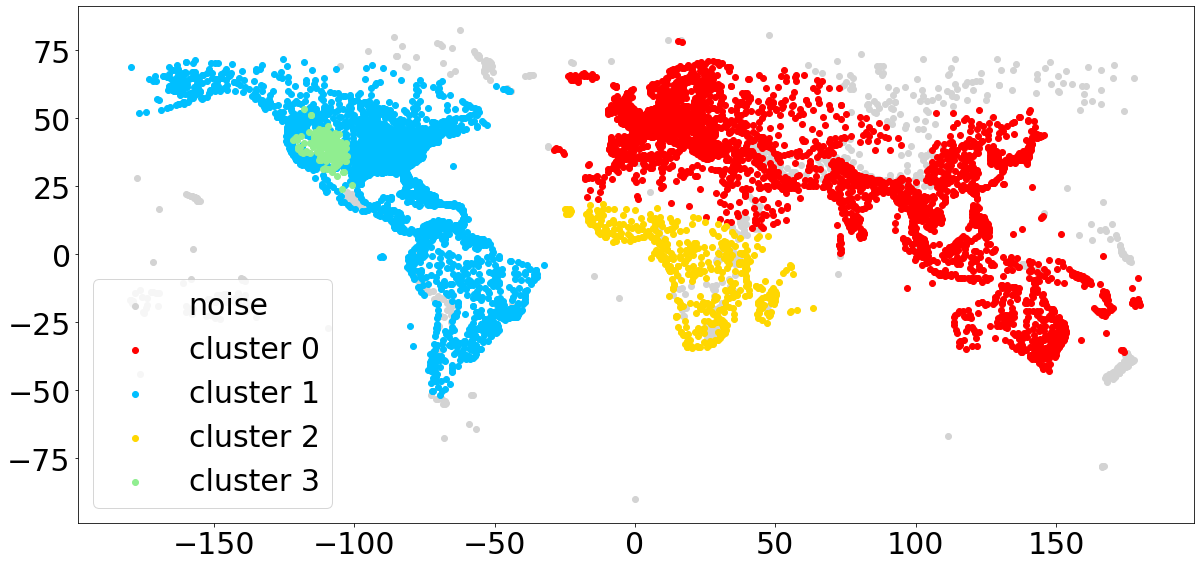

In [26]:
# Jedan od pokušaja
model_DBSCAN(df = df, x = x, eps = 0.05, min_samples = 59)

** Dobijeni senka koeficijent je 0.41025461613339476 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 6 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  514.000000  514.000000
mean    10.805141    8.937033
std     31.573861   99.648726
min    -90.000000 -179.876999
25%    -15.810125  -74.190024
50%      7.065880   34.409700
75%     33.687900   83.997652
max     82.517799  177.740997






********** Klaster 0 : **********



Udeo: 54 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  4105.000000  4105.000000
mean     25.849208    57.620494
std      28.652655    55.114606
min     -46.899700   -38.976552
25%       5.765280    10.229400
50%      34.447102    35.733334
75%      49.118332   110.375000
max      78.927498   179.951004






********** Klaster 1 : **********



Udeo: 36 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2771.000000

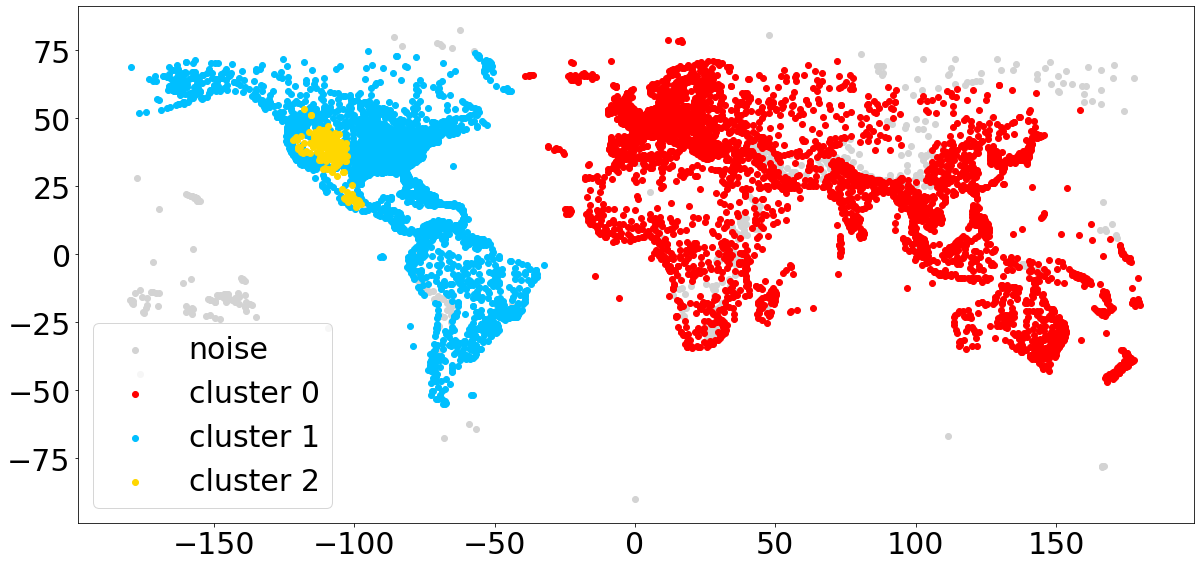

In [27]:
model_DBSCAN(df = df,x = x,eps = 0.07, min_samples = 90)

** Dobijeni senka koeficijent je 0.10855969007149902 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 12 % 
 - Deskriptivne statistike: 
         Latitude   Longitude
count  963.000000  963.000000
mean    13.624146   30.552365
std     37.023957  100.515697
min    -90.000000 -179.876999
25%    -16.686951  -53.642407
50%     11.222000   40.543442
75%     47.300801  102.113498
max     82.517799  179.951004






********** Klaster 0 : **********



Udeo: 44 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3367.000000  3367.000000
mean     31.064898    57.843494
std      25.758697    53.803074
min     -42.836102   -27.090799
25%      20.941049     9.491449
50%      38.120098    36.367409
75%      49.999201   113.173000
max      77.896944   174.365005






********** Klaster 1 : **********



Udeo: 35 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  2679.00000

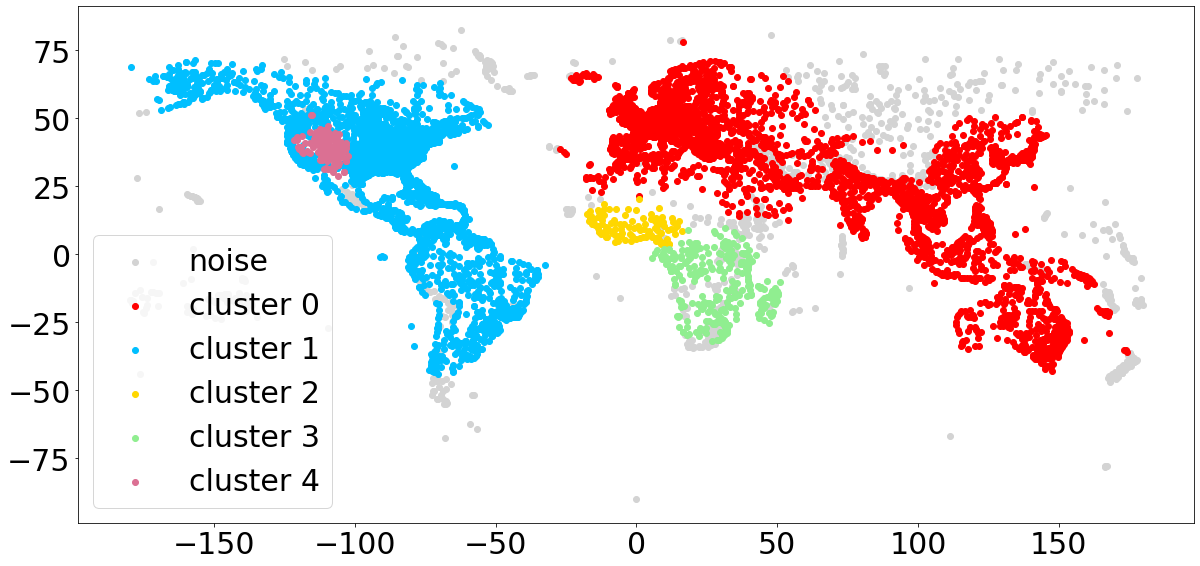

In [28]:
model_DBSCAN(df = df,x = x,eps = 0.05, min_samples= 100)

In [31]:
# Klasterovanje na osnovu atributa Latitude, Longitude i Altitude
scaler3 = MinMaxScaler()
features3 = ['Latitude','Longitude','Altitude']

x3 = df[features3]
scaler3.fit(x3)
x3 = pd.DataFrame(scaler3.transform(x3), columns = features3)

** Dobijeni senka koeficijent je 0.12943552692677104 
-- Nije dobar kvalitet klasterovanja (FAIR)
 ~ Opis dobijenih klastera: ~



********** Klaster suma (eng. Noise) : **********



Udeo: 15 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  1154.000000  1154.000000
mean      8.159695    17.703183
std      31.998972    85.425243
min     -90.000000  -179.876999
25%     -17.716074   -55.581362
50%       2.000300    34.092850
75%      34.192024    72.277654
max      82.517799   177.740997






********** Klaster 0 : **********



Udeo: 45 % 
 - Deskriptivne statistike: 
          Latitude    Longitude
count  3426.000000  3426.000000
mean     30.220422    60.467592
std      27.282766    56.825535
min     -46.899700   -38.976552
25%      17.076850     9.516655
50%      38.356704    37.998741
75%      50.457249   117.130249
max      78.927498   179.951004






********** Klaster 1 : **********



Udeo: 36 % 
 - Deskriptivne statistike: 
          Latitude    Longitude

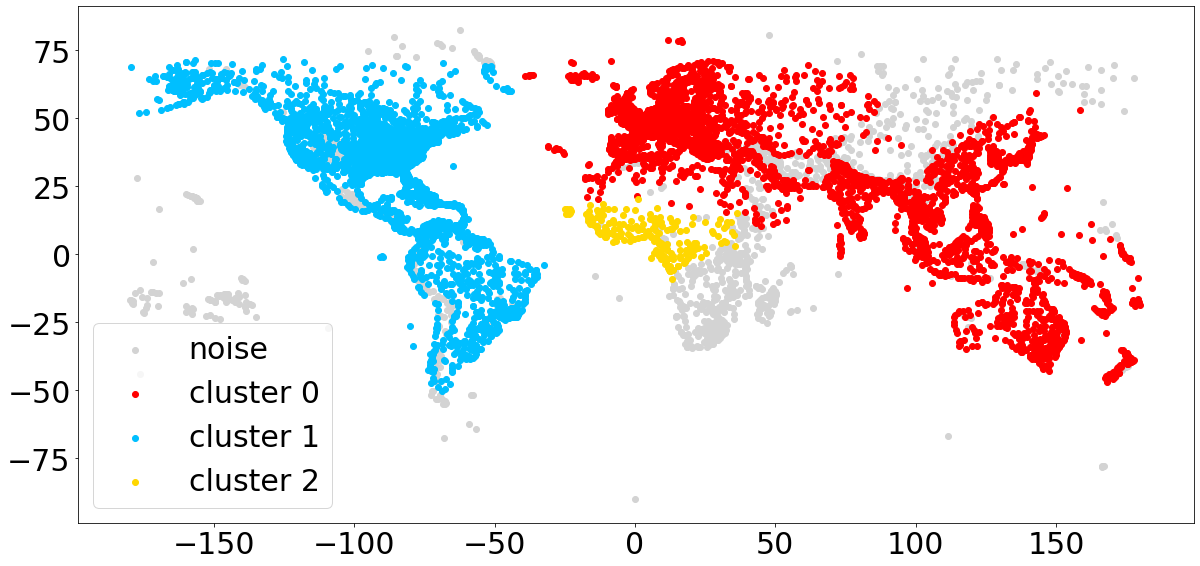

In [33]:
model_DBSCAN(df = df,x = x3,eps = 0.07, min_samples = 90)